In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Dataset
from models import TransformerModel
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

BATCH_SIZE = 32

class ActivityDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def prepare_sequences(data, sequence_length):
    sequences = []
    labels = []
    
    for i in range(0, len(data) - sequence_length, sequence_length//2):
        seq = data[i:i + sequence_length]
        if len(seq) == sequence_length:
            sequences.append(seq)
            labels.append(seq['ActivityLabel'].mode()[0])
    
    return np.array(sequences), np.array(labels)

df = pd.read_csv('data\\merged_data.csv')
    
features = ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ']
X = df[features]
y = df['ActivityLabel']

In [4]:
SEQUENCE_LENGTH = [50, 100, 200, 500]
scalers = [StandardScaler, MinMaxScaler]
weight_models = ['results\\StandardScaler', 'results\\MinMaxScaler']

In [5]:
def load_model(model_path, num_features, num_classes, device):
    model = TransformerModel(
        input_size=num_features,
        hidden_size=64,
        num_layers=3,
        num_heads=4,
        num_classes=num_classes
    ).to(device)

    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
            
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    avg_loss = total_loss / total
    acc = correct / total
    f1 = f1_score(y_true, y_pred, average='weighted')
    return avg_loss, acc, f1

Model with accuracy: 0.9873949579831933 - f1 score: 0.9873456261976448


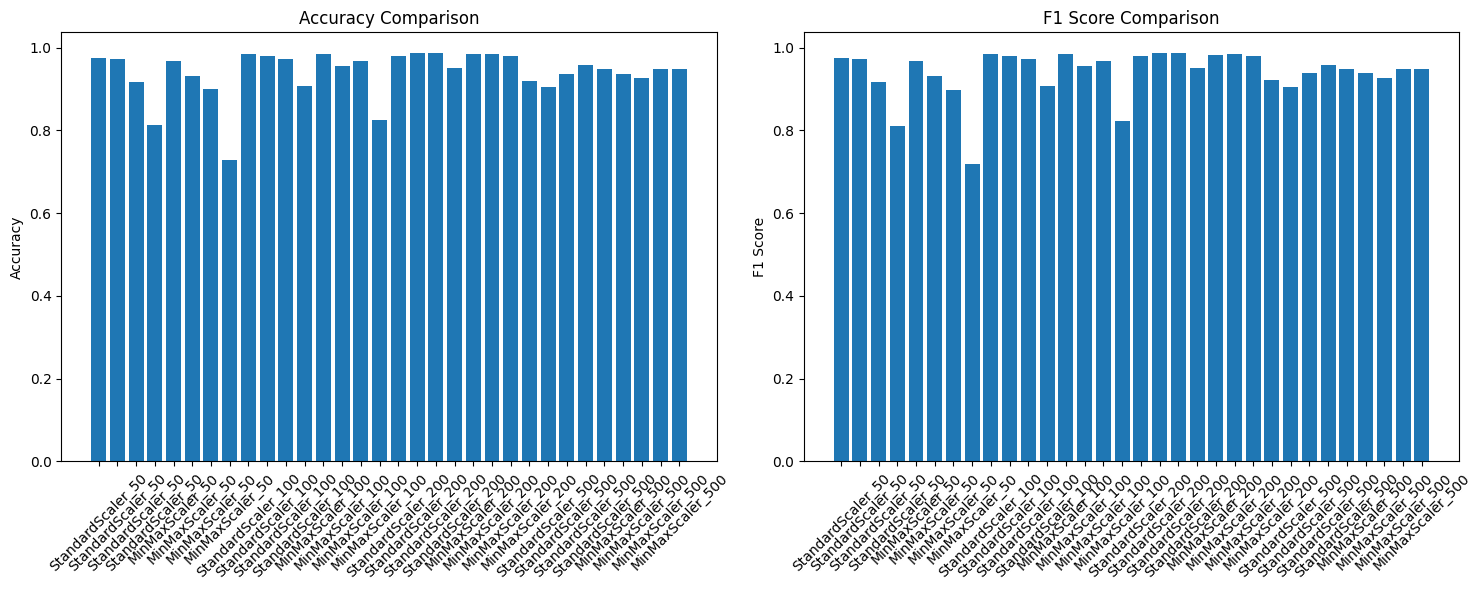

In [ ]:
best_acc = {
    'acc': 0,
    'f1': 0
}
model_paths = ''
results = {}
acc_values = []
f1_values = []
model_names = []

for sequence_length in SEQUENCE_LENGTH:
    for s_index in range(len(scalers)):
        X_scaled = scalers[s_index]().fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        
        X_scaled['ActivityLabel'] = y_encoded
        sequences, labels = prepare_sequences(X_scaled, sequence_length)
        
        sequences = sequences[:, :, :-1].astype(np.float32)
        
        X_train, X_test, y_train, y_test = train_test_split(
            sequences, labels, test_size=0.2, random_state=42
        )
        
        train_dataset = ActivityDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
        test_dataset = ActivityDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
        
        model_files = sorted([f for f in os.listdir(weight_models[s_index]) if f.endswith('.pth')], key=len)
        for model_file in model_files:
            model_path = os.path.join(weight_models[s_index], model_file)
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = load_model(model_path, num_features=6, num_classes=6, device=device)
            criterion = F.cross_entropy
            avg_loss, acc, f1 = evaluate_model(model, test_loader, criterion, device)
            
            model_name = f"{scalers[s_index].__name__}_{sequence_length}"
            acc_values.append(acc)
            f1_values.append(f1)
            model_names.append(model_name)
            
            if acc > best_acc['acc']:
                best_acc['acc'] = acc
                best_acc['f1'] = f1
                model_paths = model_path
                best_sequence_length = sequence_length
                best_scaler = scalers[s_index]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.bar(range(len(acc_values)), acc_values)
ax1.set_xticks(range(len(acc_values)))
ax1.set_xticklabels(model_names, rotation=45)
ax1.set_title('Accuracy Comparison')
ax1.set_ylabel('Accuracy')

ax2.bar(range(len(f1_values)), f1_values)
ax2.set_xticks(range(len(f1_values)))
ax2.set_xticklabels(model_names, rotation=45)
ax2.set_title('F1 Score Comparison')
ax2.set_ylabel('F1 Score')

plt.tight_layout()
plt.show()


Model with accuracy: 0.9873949579831933 - f1 score: 0.9873456261976448


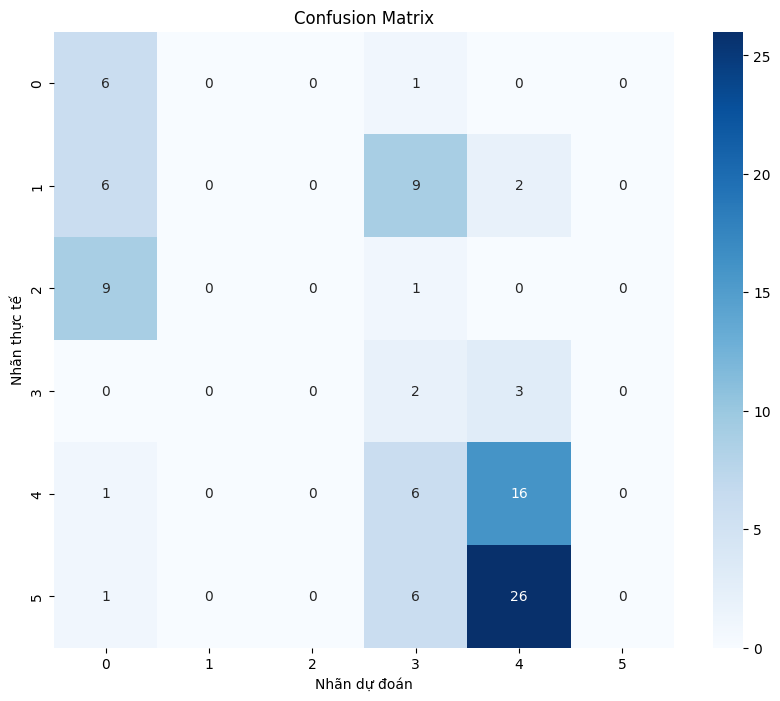

In [8]:
best_model = load_model(model_paths, num_features=6, num_classes=6, device=device)
best_model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = best_model(x)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

print(f"Model with accuracy: {best_acc['acc']} - f1 score: {best_acc['f1']}")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Nhãn thực tế')
plt.xlabel('Nhãn dự đoán')
plt.show()